# Export, Import, Clean, Merge Tutorial

The purpose of this exercise is to illustrate several wrangling concepts covered in class and in DataCamp. We begin by “messing up” the diamonds data then put it back together. During this exercise, you will see imports, exports, reshapes, joins, mutations, and more!

## Housekeeping

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Deconstruct the diamonds dataset
Open and store the diamonds dataset after applying a filter on carat weight (less than 1.5 carats) and keeping only carat, clarity, and price. Also, let's create a unique identifier (`uniq_id`) for each diamond. Information about the original dataset can be found [here](https://ggplot2.tidyverse.org/reference/diamonds.html). Store in a new dataset called `diamonds_subset`. This will be our starting point for the exercise.

In [2]:
diamonds = sns.load_dataset('diamonds')
# diamonds = pd.read_pickle('diamonds.pkl')

diamonds_subset = (
    diamonds[diamonds['carat'] < 1.5][['carat', 'clarity', 'price']]
    .assign(uniq_id=lambda d: range(1, len(d) + 1)) # add a unique identifier
    .reset_index(drop=True)
)

Take a look at a sample of the data:

In [3]:
diamonds_subset.sample(10, random_state=42)

,carat,clarity,price,uniq_id
19466,1.31,VS2,8979,19467
16982,1.30,VS1,6931,16983
11948,1.01,SI1,5147,11949
40517,0.61,SI1,1800,40518
7916,1.02,SI2,4319,7917
12151,1.15,SI2,5193,12152
23120,0.31,VS2,698,23121
4537,0.82,VS2,3641,4538
26082,0.36,VS2,789,26083
37702,0.30,SI1,515,37703


Select the `uniq_id` and `price` variables, rename the `uniq_id` as `id`, and add extra characters to `price`. Create a new dataset called `diamonds_prices`:

In [4]:
diamonds_prices = (
    diamonds_subset[['uniq_id', 'price']]
    .rename(columns={'uniq_id': 'id'})
)

diamonds_prices['price'] = 'amount ' + diamonds_prices['price'].astype(str) + ' USD'

Add a few duplicated observations to `diamonds_prices` using a random draw from `diamonds_prices`:

In [5]:
sampled = diamonds_prices.sample(55, random_state=42) # Take a random sample of 55 rows

diamonds_prices = (
    pd.concat([diamonds_prices, sampled]) # Append the sampled rows to the original diamonds_prices dataframe
    .sort_values('id')
)

del sampled

Next, let's store the other diamond characteristics (i.e., carat and clarity) in another 'messy' dataset. Select the diamond characteristics excluding `price` and reshape to long format. Store as a new dataset - `diamonds_char_long`:

In [6]:
diamonds_char = (
    diamonds_subset
    .drop(columns='price')
    .melt(id_vars='uniq_id', var_name='variable', value_name='measure')
    .sort_values(['uniq_id', 'variable'])
)

Save each of the new datasets in different formats (csv and txt) and delete all variables/data from the workspace:

In [7]:
diamonds_prices.to_csv('diamonds_prices.csv', index=False)
diamonds_char.to_csv('diamonds_char.txt', sep='\t', index=False)

del diamonds, diamonds_subset, diamonds_prices, diamonds_char

## Reconstruct the diamonds dataset
Take a look at your working directory (i.e., the current folder we are working in). You should have two files saved from above. These files include all of the information from the original dataset (`diamonds_subset`), but the data is now in raw and messy form ☹️. Let's imagine that we are starting from scratch with only these files and need to reconstruct the diamonds dataset. Before we begin, find the files on your local computer and open them. To navigate to the file location, right-click on the file/folder and select 'open in' then select explorer (or finder on a Mac).

Let’s begin by importing each dataset as `diamonds_prices_import` and `diamonds_char_import`:

In [8]:
diamonds_prices_import = pd.read_csv('diamonds_prices.csv')
diamonds_char_import = pd.read_csv('diamonds_char.txt', sep='\t')

Take a look at a sample of the `diamonds_prices` data.

In [9]:
diamonds_prices_import.sample(10, random_state=42)

,id,price
41399,41348,amount 1875 USD
19354,19328,amount 8849 USD
44583,44530,amount 2300 USD
8842,8833,amount 4482 USD
35345,35303,amount 1235 USD
16796,16775,amount 612 USD
19200,19174,amount 8674 USD
21492,21463,amount 647 USD
7956,7948,amount 4324 USD
41027,40979,amount 1838 USD


As you can see, the price variable needs to be cleaned. We need to remove the text and keep only the price. Let’s tackle it!

In [10]:
# Copy diamonds_prices_import in diamonds_prices for cleaning
diamonds_prices = diamonds_prices_import.copy()

# Remove "amount " from the price column
diamonds_prices['price'] = diamonds_prices['price'].str.replace('amount ', '', regex=False)

# Split the price column into two columns: the price and currency
diamonds_prices[['price', 'currency']] = diamonds_prices['price'].str.split(' ', expand=True)

# Convert the numeric price (currently a string) into numeric type
diamonds_prices['price'] = pd.to_numeric(diamonds_prices['price'])

diamonds_prices.sample(10, random_state=42)

,id,price,currency
41399,41348,1875,USD
19354,19328,8849,USD
44583,44530,2300,USD
8842,8833,4482,USD
35345,35303,1235,USD
16796,16775,612,USD
19200,19174,8674,USD
21492,21463,647,USD
7956,7948,4324,USD
41027,40979,1838,USD


Recall that we added some duplicates to the prices dataset… let’s check for duplicates and store in a variable called `duplicates`.

In [11]:
duplicates = diamonds_prices[diamonds_prices.duplicated(subset=['id'], keep=False)]

duplicates.head()

,id,price,currency
2514,2515,3201,USD
2515,2515,3201,USD
3932,3932,3500,USD
3933,3932,3500,USD
4539,4538,3641,USD


This reports the duplicated observations in the dataset. Take a look at the `duplicates` dataframe. There are 110 rows and 55 duplicated observations. A quick inspection suggests that the duplicates are exact copies of each other. We can remove the duplicates by keeping only the first occurrence of each duplicated `id`.

In [12]:
diamonds_prices = diamonds_prices.drop_duplicates(subset=['id'], keep='first')

Next, we need to work with the diamonds_char_import dataset. Let's start by inspecting the dataset:

In [13]:
diamonds_char_import.head(8)

,uniq_id,variable,measure
0,1,carat,0.23
1,1,clarity,SI2
2,2,carat,0.21
3,2,clarity,SI1
4,3,carat,0.23
5,3,clarity,VS1
6,4,carat,0.29
7,4,clarity,VS2


At first glance, this dataset seems to have many duplicate values for `uniq_id`. However, a closer look suggests that each row contains different information about each diamond. Remember what we learned about *tidy data*... Each observation (i.e., diamond) should be in a row, and each feature (i.e., carat and clarity) should be a column. To get there, the dataset needs to be reshaped from long to wide. Let’s do that now.

In [14]:
# Copy diamonds_char_import in diamonds_char for cleaning
diamonds_char = diamonds_char_import.copy()

# Reshape the diamonds_char dataset from long to wide
diamonds_char = diamonds_char.pivot(
    index='uniq_id',
    columns='variable',
    values='measure'
).reset_index()

diamonds_char.head(4)

variable,uniq_id,carat,clarity
0,1,0.23,SI2
1,2,0.21,SI1
2,3,0.23,VS1
3,4,0.29,VS2


That’s better. However, all formatting from the variables is lost. In particular, we need to convert carat to a numeric variable and clarity to an ordered categorical (or factor) variable:

In [15]:
diamonds_char['carat'] = pd.to_numeric(diamonds_char['carat'])

diamonds_char['clarity'] = pd.Categorical(
    diamonds_char['clarity'],
    categories=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'],
    ordered=True
)

diamonds_char.head(4)

variable,uniq_id,carat,clarity
0,1,0.23,SI2
1,2,0.21,SI1
2,3,0.23,VS1
3,4,0.29,VS2


As a sanity check, let’s inspect the dataset for duplicate observations:



In [16]:
#Check for duplicates in the reshaped dataset
duplicates = diamonds_char[diamonds_char.duplicated(subset=['uniq_id'], keep=False)]

duplicates.head()

variable,uniq_id,carat,clarity


OK, no duplicates this time… we are finally ready to join! Remember that we tracked each diamond with a unique identifier. We will use that to reconnect the two datasets.

In [17]:
diamonds_recon = pd.merge(
    diamonds_prices,
    diamonds_char,
    left_on='id',
    right_on='uniq_id',
    how='inner',
    validate='one_to_one'
)

diamonds_recon.head()

,id,price,currency,uniq_id,carat,clarity
0,1,326,USD,1,0.23,SI2
1,2,326,USD,2,0.21,SI1
2,3,327,USD,3,0.23,VS1
3,4,334,USD,4,0.29,VS2
4,5,335,USD,5,0.31,SI2


Let’s plot our reconstructed dataset:



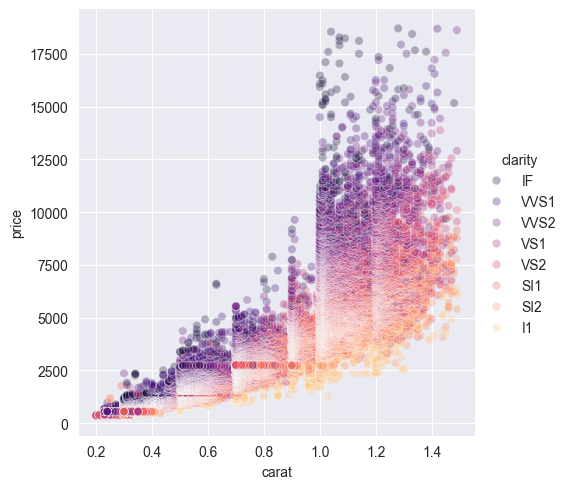

In [18]:
sns.relplot(data=diamonds_recon,
            x='carat',
            y='price',
            hue='clarity',
            kind='scatter',
            alpha=0.3,
            palette=sns.color_palette('magma', n_colors=len(diamonds_recon['clarity'].unique()))
            )

plt.show()